# This cell has two classes:
1. `EnvChannel`: Defines the environment
2. `ControlAgent`: Defines the control agent

# Parameters:
1. ```alpha```: Learning rate of agent
2. `gamma`: Discount factor
3. `epsilon`: for epsilon-greedy policy
4. `num_states`: Number of states in system, currently three(Good, Medium, Bad)
5. `d1`: Delay threshold for Good state and medium state
6. `d2`: Delay threshold for Medium and bad state

# Return:
1. ```action (int)```: -1: Decrease Resolution; 0: No change; 1: Increase Resolution
2. `state (int)`: 0: Bad; 1: Medium; 2: Good


# Arguments:
1. `state_list`: List of integer states. 
2. `avg_confidence`: (Float) Average confidence 
    
# Sample use:

Initialize ControlAgent class:
```
agent = ControlAgent(resolution_list=[100,200,300], d1=0.00103,d2=0.00161)
```
To train and get optimal actions
```
action = agent.get_signal(delay_list = [.5,.6], curr_resolution=200, error _score=.5)
```

To get random actions:
```
agent = ControlAgent(resolution_list=[100,200,300], d1=0.00103,d2=0.00161, random_actions=True)
```

# To Do:
1. ~~Instead of taking state_list directly, estimate the states indirectly from packet delay.~~ **Done**
2. ~~Update the function get_delay_factor.~~ **Done** 


In [12]:
import numpy as np
import pickle
import sys, os, math
import datetime


# Define an environment channel class for reinforcement learning.
class EnvChannel:
    def __init__(self, resolution_list, d1=.01, d2=.02):
        # Initialize the environment with given parameters.
        self.num_delay_bins = 3  # Number of delay bins (states)
        self.num_resolutions = len(resolution_list)  # Number of resolutions
        resolution_list = np.sort(resolution_list)
        self.resolution_dict = {resolution: i for i, resolution in enumerate(resolution_list)}  # Map resolutions to indices
        
        # Calculate the total number of states, initialize current and previous states, and other attributes.
        self.num_states = self.num_delay_bins * self.num_resolutions
        self.curr_state = (0, 0) # delay, resolution
        self.prev_state = (0, 0)
        self.reward = 0
        self.action = 0
        self.num_actions = 3  # Number of possible actions
        self.valid_actions = [0, 1, 2]  # Valid actions: Reduce, No change, Increase
        self.d1 = d1  # Threshold for "good" delay state
        self.d2 = d2  # Threshold for "medium" delay state
        self.avg_delay = 0
        self.curr_resolution = 0
        self.deviation_error = 0
        self.deviation_state = 0

    def sample_action(self):
        # Randomly sample an action from the valid actions.
        return np.random.choice(self.valid_actions)

    def get_reward(self):
        # Calculate the reward based on the current state and error score.
        return 0.5 / (self.delay_state**2 + 1) + 0.5 *  self.deviation_state

    def step(self, action):
        # Perform a step in the environment based on the chosen action.
        self.action = action
        self.reward = self.get_reward() #negative of the rewards
        return self.reward, self.estimate_state()

    def estimate_state(self):
        # Estimate the current state based on resolution and average delay.
        self.resolution_state = self.resolution_dict[self.curr_resolution]
        if self.avg_delay <= self.d1:
            self.delay_state = 0  # Good state
        elif self.avg_delay <= self.d2:
            self.delay_state = 1  # Medium state
        else:
            self.delay_state = 2  # Bad state
        self.curr_state = (self.delay_state, self.resolution_state)
        return self.curr_state

    def reset(self):
        # Reset the environment to its initial state.
        self.__init__(num_states=self.num_states)
        return self.curr_state

# Define a control agent class for reinforcement learning.
class ControlAgent:
    def __init__(self, resolution_list, d1, d2, alpha=0.1, gamma=0.1, epsilon=0.9, random_actions=False):
        # Initialize the control agent with various parameters.
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration probability
        self.env = EnvChannel(resolution_list, d1, d2)  # Create an environment instance
        self.q_table = np.zeros([self.env.num_delay_bins, self.env.num_resolutions, self.env.num_actions])  # Q-table for storing action values

        self.all_epochs = []  # List to record training epochs
        self.action_record = []  # List to record taken actions
        self.state_record = []  # List to record observed states
        self.penalties = []  # List to record penalties (rewards)
        self.iteration_i = 0  # Iteration counter
        self.prev_state = None  # Previous state
        self.prev_avg_delay = 0  # Previous average delay
        self.random_actions = random_actions  # Flag for random actions
        self.path = "Channel_Data"
        self.f_name = "/Data_"+datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")+".pkl"
        self.q_table_hist = []
        self.create_directory()
        self.q_table_count_unchanged = 0
        self.q_table_converged_iter = 0
        self.epsilon_decay = 0.1
        self.q_table_prev = self.q_table.copy()
        self.iter_data = 0
        
        
    def create_directory(self):
        # check if channel_data directory exists
        if not os.path.exists(self.path):
            os.mkdir(self.path)

    def map_action(self, state):
        # Map an action to a change in delay state.
        if state == 0:
            return -1  # Reduce delay
        if state == 1:
            return 0  # No change in delay
        if state == 2:
            return 1  # Increase delay
            
    def get_deviation_state(self, deviation):
    	if deviation==0:
    		return 0
    	elif deviation <= 25:
    		return 1
    	elif deviation <= 50:
    		return 2
    	else:
    		return 3
    	

    def get_signal(self, delay_list, curr_resolution, deviation_error):
        
        self.q_table_prev = self.q_table.copy()
        
        # Receive input signals and update the agent's knowledge.
        self.env.avg_delay = np.average(delay_list)  # Update average delay
        self.env.curr_resolution = curr_resolution  # Update current resolution
        self.env.deviation_state = self.get_deviation_state(deviation_error)
        # self.env.deviation_error = -np.abs(deviation_error) / 100.0  # Update error score (normalized)
        
        self.iteration_i += 1  # Increment iteration counter
        
        # Decay alpha and epsilon values over time.
        self.alpha = np.max([.001, self.alpha * (1-self.epsilon_decay)]) 
        self.epsilon = np.max([.001, self.epsilon * (1-self.epsilon_decay)])


        if self.iteration_i == 1:
            state = self.env.estimate_state()
            action = self.env.sample_action()
            reward = 0
        else:
            reward, state = self.env.step(self.prev_action)

            if not self.random_actions:
                old_qvalue = self.q_table[self.prev_state[0], self.prev_state[1], self.prev_action]
                next_max = np.max(self.q_table[state[0], state[1], :])

                # Update Q-value using Q-learning equation.
                new_qvalue = (1 - self.alpha) * old_qvalue + self.alpha * (reward + self.gamma * next_max)
                self.q_table[self.prev_state[0], self.prev_state[1], self.prev_action] = new_qvalue
                self.penalties.append(reward)
                self.action_record.append(self.prev_action)

                if np.random.uniform(0, 1) < self.epsilon:
                    action = self.env.sample_action()  # Explore action space
                else:
                    # Exploit learned values to select an action.
                    action = np.argmax(self.q_table[state[0], state[1], :])
            else:
                action = self.env.sample_action()  # Explore action space

        self.prev_state = state  # Update previous state
        self.prev_action = action  # Update previous action
        self.q_table_hist.append(self.q_table.copy())
        if (self.q_table_prev == self.q_table).all():
            self.q_table_count_unchanged += 1
            if self.q_table_count_unchanged==10:
                self.q_table_converged_iter = self.iteration_i
        else:
            self.q_table_count_unchanged = 0
        
        if self.iteration_i%20 == 0: 
            with open(self.path+self.f_name,'wb') as fp:
                pickle.dump([self.q_table_hist, self.alpha, self.epsilon, self.iter_data], fp)
        # combine total iterations and number of iterations it took for convergence into iter_data
        self.iter_data = self.q_table_converged_iter + (1.0*self.iteration_i)/10**(int(math.log10(self.iteration_i))+1)
        return self.map_action(action), state, reward, self.iter_data  # Return mapped action, current state, and reward

In [13]:
agent = ControlAgent(resolution_list=[100,200,300], d1=0.00103,d2=0.00161)
action = agent.get_signal(delay_list = [.5,.6], curr_resolution=200, deviation_error=.5)

### For Testing

In [7]:
agent = ControlAgent(resolution_list=[300,500,700], d1=0.00103,d2=0.00161)
avg_delay = []
rerun_list = []
for i in range(len_df):
    avg_delay.append(data_df["Delays"][i])
    age_deviation.append(data_df["Age Deviation"][i])
        
    if i != 0:
        if data_df["Loop Packet Count"][i] == 1  or i== len_df-1:
            reso = data_df["Resolution"][i-1]
            action = agent.get_signal(delay_list = avg_delay, curr_resolution=reso, error_score=.5)
            avg_delay = []
            rerun_list.append([action, reso])
            
rerun_list    

NameError: name 'len_df' is not defined

### Results Analysis

In [3]:

import datetime, re
import numpy as np
import pandas as pd
# xl_file=pd.ExcelFile("Downloads/Results_06_09_23.xlsx")
# f_name = '../../../../../../Downloads/Results_21_09_23.xlsx'
# f_name = '../../../../../../Downloads/Summary.csv'

# data_df = pd.read_excel(f_name, sheet_name=1)

def result_summarize(data_df):
    # Calculate the length of the input DataFrame
    len_df = len(data_df)
    
    # Define column names for the summary DataFrame
    column_names = ["Loop", "Action", "Control_State", "Reward", "Resolution", "Avg_delay", "HMM_State_Most", 
                    "HMM_State_Proportion", "Age_deviation", "Avg_conf_score"]
    
    # Create an empty summary DataFrame with defined column names
    summary_df = pd.DataFrame(columns=column_names)

    # Initialize variables for loop count, HMM state count, average delay, age deviation, and average confidence score
    loop_count = 0
    hmm_state_cnt = np.zeros([4,])
    avg_delay = []
    age_deviation = []
    avg_conf = []

    # Iterate over each row in the input DataFrame
    for i in range(len_df):
        # Check if it's not the first row and the condition for a new loop is met
        if i != 0 and (data_df["Loop Packet Count"][i-1] > data_df["Loop Packet Count"][i] or i == len_df-1):
            # Extract relevant information for the summary DataFrame
            action = data_df["Action"][i-1]
            control_state = data_df["Channel State"][i-1]
            reward = data_df["Reward"][i-1]
            reso = data_df["Resolution"][i-1]
            avg_conf = data_df["Avg Conf Score"]
            hmm_most = np.argmax(hmm_state_cnt)
            hmm_prop = np.max(hmm_state_cnt)/np.sum(hmm_state_cnt)

            # Append delay and age deviation to respective lists
            avg_delay.append(data_df["Delays"][i])
            age_deviation.append(data_df["Age Deviation"][i])

            # Add calculated values to the summary DataFrame
            summary_df.loc[loop_count] = [loop_count, action, control_state, reward, reso, np.average(avg_delay), 
                                          hmm_most, hmm_prop, np.average(age_deviation), np.average(avg_conf)]

            # Reset values for next loop
            hmm_state_cnt = np.zeros([4,])
            avg_delay = []
            age_deviation = []
            loop_count += 1

            # Update HMM state count
            hmm_state_cnt[data_df["State Array"][i]] += 1

    # Return the summary DataFrame and the last control state value
    return summary_df, control_state


def saveExcel(data_df):
    current_time = str(datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S"))
    data_df.to_csv(f"../../../../../../Downloads/{current_time}_Summary.csv")


In [7]:
import pandas as pd
import glob

# get data file names
filenames = glob.glob("Results/files/*.xlsx")
dfs = []
filename = "Results/files/part_"
for i in range(len(filenames)):
    print(f"Reading file: {filename+str(i+2)}.xlsx")
    try:
        dfs.append(pd.read_excel(filename+str(i+2)+".xlsx"))
    except:
        print("wrong file")


# Concatenate all data into one DataFrame
data_df = pd.concat(dfs, ignore_index=True)

# Create summary and save it
summary_df, control_state = result_summarize(data_df)
saveExcel(summary_df)

C:\Users\Abhinav\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


## Plot results

(0, 0)
(0, 1)
(0, 2)
(1, 0)
(1, 1)
(1, 2)
(2, 0)
(2, 1)
(2, 2)


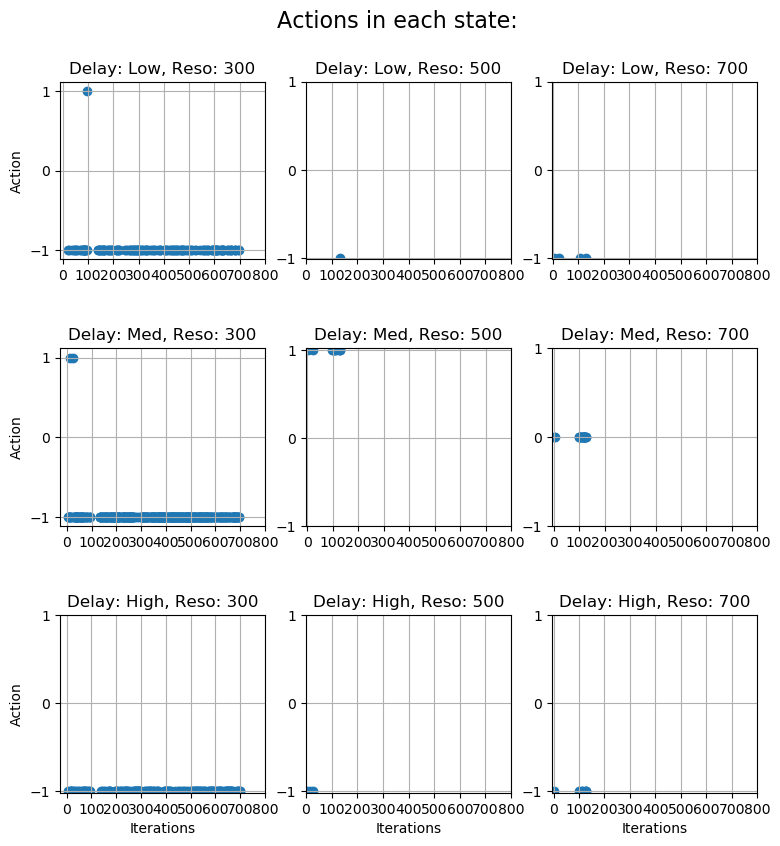

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import datetime

states = ["(0, 0)", "(0, 1)", "(0, 2)", "(1, 0)", "(1, 1)", "(1, 2)", "(2, 0)", "(2, 1)", "(2, 2)"]

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

delay_dict = {0: "Low",
             1: "Med",
             2: "High"}
reso_dict = { 0: 300,
             1: 500,
             2: 700}
# summary_df = pd.read_excel("2023_10_20-20_59_24_Summary.csv")
# Iterate through states
for i, state in enumerate(states):
    row, col = divmod(i, 3)  # Calculate row and column index
    ax = axes[row, col]  # Get the current subplot

    # Filter data based on the current state
    mask = summary_df['Control_State'] == state
    X = summary_df.loc[mask, 'Loop']
    Y = summary_df.loc[mask, 'Action']

    # Create scatter plot
    ax.scatter(X, Y)
    ax.grid()
    print(state)
    ax.set_title(f"Delay: {delay_dict[int(state[1])]}, Reso: {reso_dict[int(state[4])]}")
#     ax.set_title(f"Delay: {state}")

    # Set labels
    if row == 2:
        ax.set_xlabel("Iterations")
    if col == 0:
        ax.set_ylabel("Action")

    # Set common ticks for all subplots
    ax.set_xticks(np.arange(0, 801, 100))
    ax.set_yticks(np.arange(-1, 2, 1))

# Add a common title and adjust layout
fig.suptitle('Actions in each state:', fontsize=16)
plt.subplots_adjust(top=0.9, hspace=0.5)

# # Save the figure
# unique_str = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
# plt.savefig(f"data/{unique_str}state-action.pdf")

# Show the plot (optional)
# plt.show()


## plot cumulative rewards

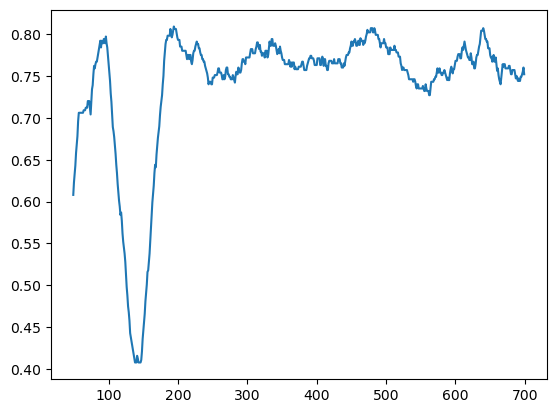

In [11]:
cumm_mean_df = summary_df["Reward"].rolling(window=50).mean()

plt.plot(cumm_mean_df)

In [3]:
import pickle
import numpy as np
# fname = "../../../../../../Downloads/Data_2023_10_20-13_03_19.pkl"
fname = "Results/files/Data_2024_02_03-18_52_19.pkl"
with open (fname, 'rb') as fp:
    q_tables, a, e  = pickle.load(fp)
# print(q_table)

q_table_data = np.zeros([3,3,3,len(q_tables)])
#     print("Delay \tResolution \tAction: -1, Action: 0, Action: 1")
for i in range(3): # Delay
    for j in range(3): # Resolution
        for k in range(3): # Action
            for l in range(len(q_tables)):
#                 print(i,j,k,l)
                q_table_data[i,j,k,l] = q_tables[l][i,j,k]


In [4]:
e

0.024825321393097472

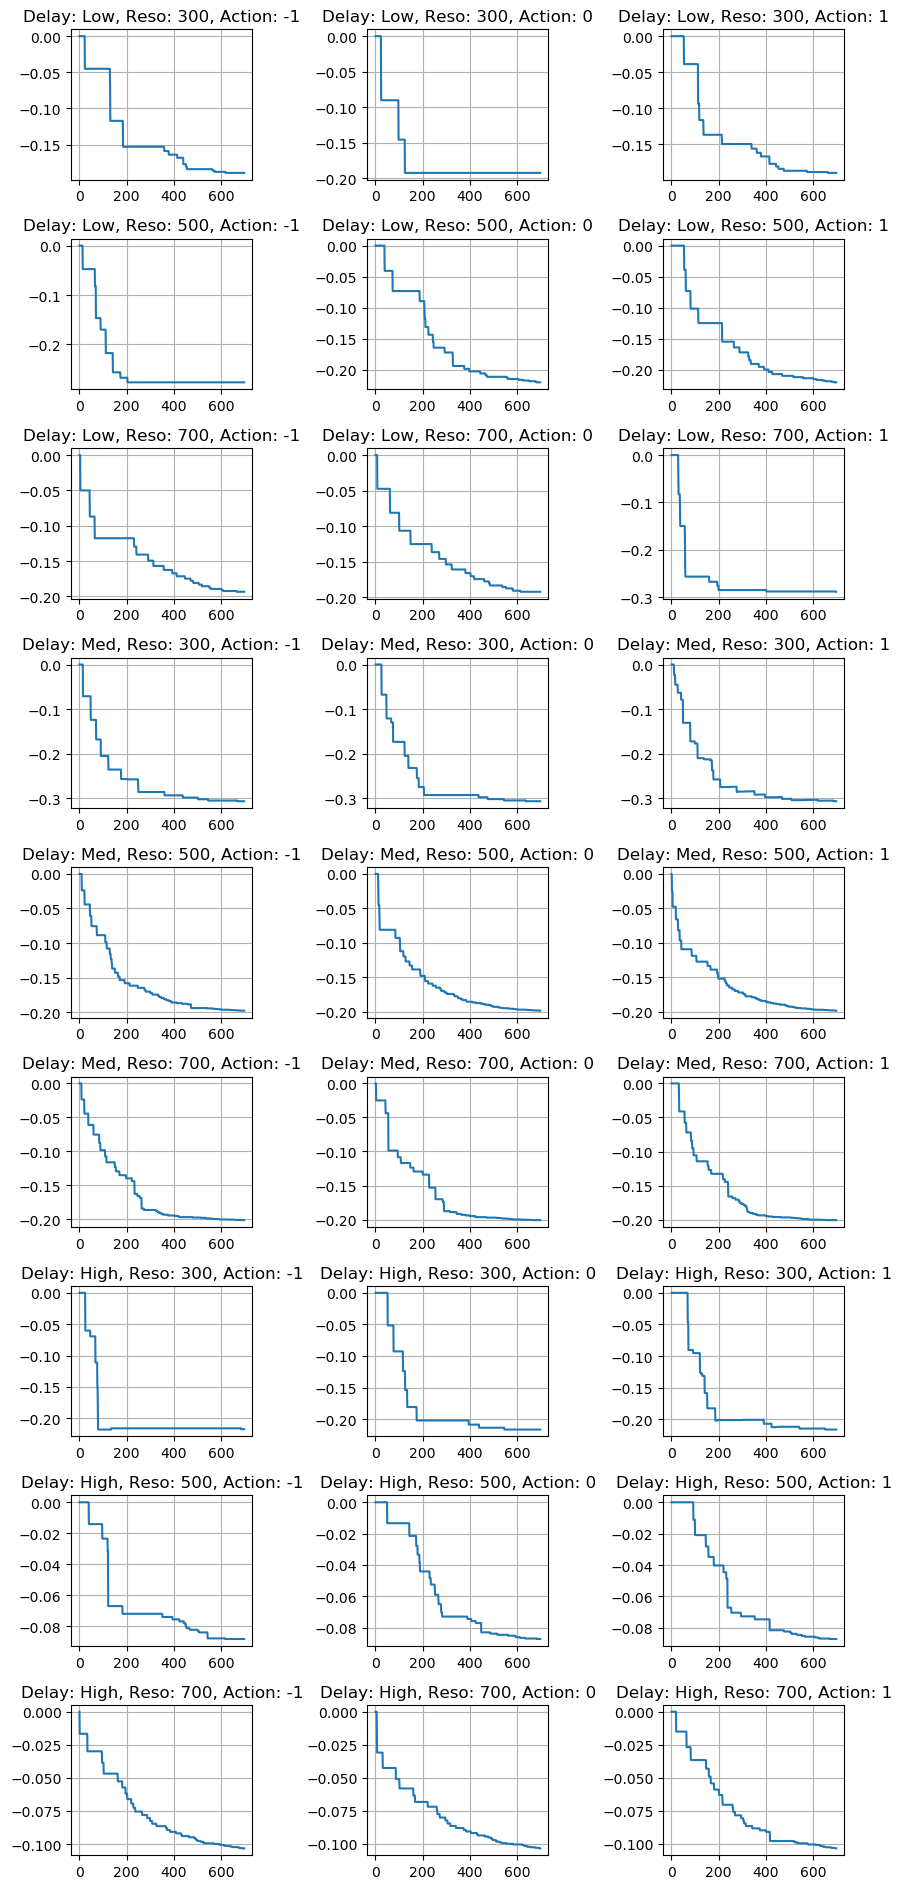

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import datetime

# Create subplots
fig, axes = plt.subplots(9, 3, figsize=(9, 19))

# Iterate through states
for i in range (3): # delay
    for j in range(3): # resolution
        for k in range(3): # action
            row, col = 3*i+j,k  # Calculate row and column index
#             print(i,j,k, row, col)
            ax = axes[row, col]  # Get the current subplot

            # Filter data based on the current state
            X = q_table_data[i,j,k,:]

#             if X[0] != X[-1]:
#                 print(i,j,k)

            # Create scatter plot
            ax.plot(X)
            ax.grid()
    #             print(state)
            ax.set_title(f"Delay: {delay_dict[i]}, Reso: {reso_dict[j]}, Action: {k-1}")
        #     ax.set_title(f"Delay: {state}")

            # Set labels
    #             if row == 2:
    #                 ax.set_xlabel("Iterations")
    #             if col == 0:
    #                 ax.set_ylabel("Action")

            # Set common ticks for all subplots
    #             ax.set_xticks(np.arange(0, 501, 100))
    #             ax.set_yticks(np.arange(-1, 2, 1))

# Add a common title and adjust layout
# fig.suptitle('Actions in each state:', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.tight_layout()
# # Save the figure
unique_str = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
plt.savefig(f"data/{unique_str}state-action.pdf")

# Show the plot (optional)
# plt.show()


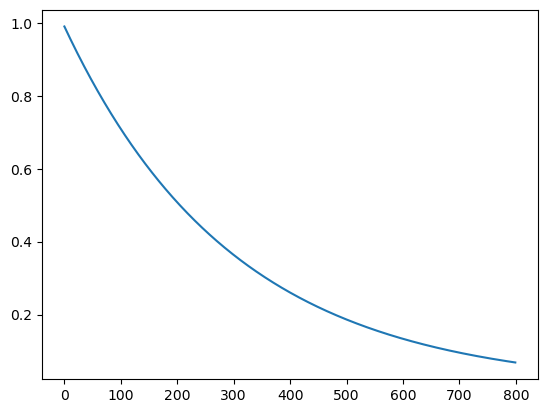

In [17]:
tmp_alpha = []
tmp_epsilon = []
alpha = .1  # Learning rate
epsilon = .99  # Exploration probability
epsilon_decay = 0.01  # Exploration probability decay
epsilon_min = .01  
for i in range(800):
    tmp_alpha.append(alpha)
    tmp_epsilon.append(epsilon)
    alpha = np.max([.001, alpha * (1-epsilon_decay/3)]) 
    epsilon = np.max([epsilon_min, epsilon * (1-epsilon_decay*1/3)])
    
plt.plot(tmp_epsilon)


### Plot EIA performance

In [ ]:
states = ["(0, 0)", "(0, 1)", "(0, 2)", "(1, 0)", "(1, 1)", "(1, 2)", "(2, 0)", "(2, 1)", "(2, 2)"]

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

delay_dict = {0: "Low",
             1: "Med",
             2: "High"}
reso_dict = { 0: 300,
             1: 500,
             2: 700}
# Iterate through states
for i, state in enumerate(states):
    row, col = divmod(i, 3)  # Calculate row and column index
    ax = axes[row, col]  # Get the current subplot

    # Filter data based on the current state
    mask = summary_df['Control_State'] == state
    X = summary_df.loc[mask, 'Loop']
    Y = summary_df.loc[mask, 'Action']

    # Create scatter plot
    ax.scatter(X, Y)
    ax.grid()
    print(state)
    ax.set_title(f"Delay: {delay_dict[int(state[1])]}, Reso: {reso_dict[int(state[4])]}")
#     ax.set_title(f"Delay: {state}")

    # Set labels
    if row == 2:
        ax.set_xlabel("Iterations")
    if col == 0:
        ax.set_ylabel("Action")

    # Set common ticks for all subplots
    ax.set_xticks(np.arange(0, 801, 100))
    ax.set_yticks(np.arange(-1, 2, 1))

# Add a common title and adjust layout
fig.suptitle('Actions in each state:', fontsize=16)
plt.subplots_adjust(top=0.9, hspace=0.5)

# # Save the figure
# unique_str = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
# plt.savefig(f"data/{unique_str}state-action.pdf")

# Show the plot (optional)
# plt.show()
